In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from xasdenoise.xas_data import data_io, visualization
from xasdenoise.denoising_methods.denoisers import EncoderDenoiser
from xasdenoise.denoising_pipeline import PipelineConfig, DenoisingPipeline

# Set global font size for all plots
plt.rcParams['figure.dpi'] = 120
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 18})  # Update the default font size for all text
plt.rcParams.update({'axes.titlesize': 18})  # Update the default font size for axes titles
plt.rcParams.update({'axes.labelsize': 18})  # Update the default font size for axes labels
plt.rcParams.update({'xtick.labelsize': 18})  # Update the default font size for x tick labels
plt.rcParams.update({'ytick.labelsize': 18})  # Update the default font size for y tick labels

# Load an example dataset
Either load the basic arrays from the csv file. Also we can load the previously created Spectrum object which contains various pre-computed arrays and values. 

Loaded None spectrum.
Loaded 1 spectra from ./data/processed_spectrum.h5


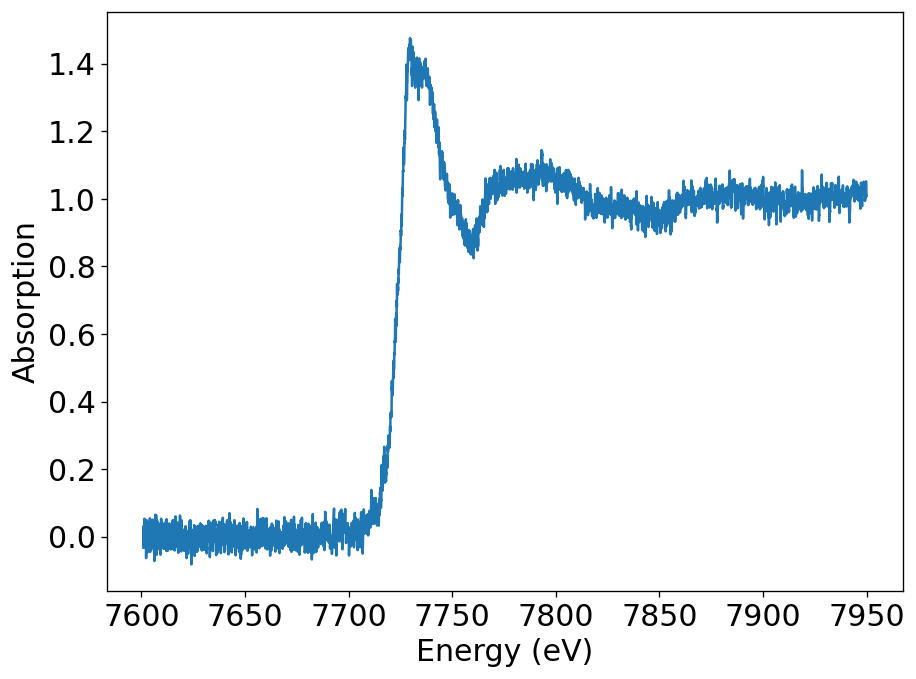

In [2]:
# Load the data from a CSV file
# folder_path = './data/processed_spectrum.csv'
# csv_file = pd.read_csv(folder_path)
# energy = csv_file.iloc[:, 0].values
# mu = csv_file.iloc[:, 1].values
# spectrum0 = Spectrum(energy=energy, spectrum=mu[:, np.newaxis])

# Load the Spectrum object from an h5 file
spectrum0 = data_io.load_spectra_from_h5('./data/processed_spectrum.h5')

# Bin the spectrum to reduce the number of points (GPs are very slow with large datasets)
# spectrum0.bin_spectrum(size=5000)
visualization.plot_spectrum(spectrum0)


# Encoder Denoiser
We need to initialize a denoising model and load a pre-trained model for denoising.

Using Apple Silicon MPS device.
Model loaded from ./data/encoder_denoiser_conv_model_5000_pts_num_times_all_train_90.0_test_10.0_val_0_energy_grid_linear_in_energy_downsampled_data_warped_False_nlayers_4_kernelsize_9_noise2noise_checkpoint.pth


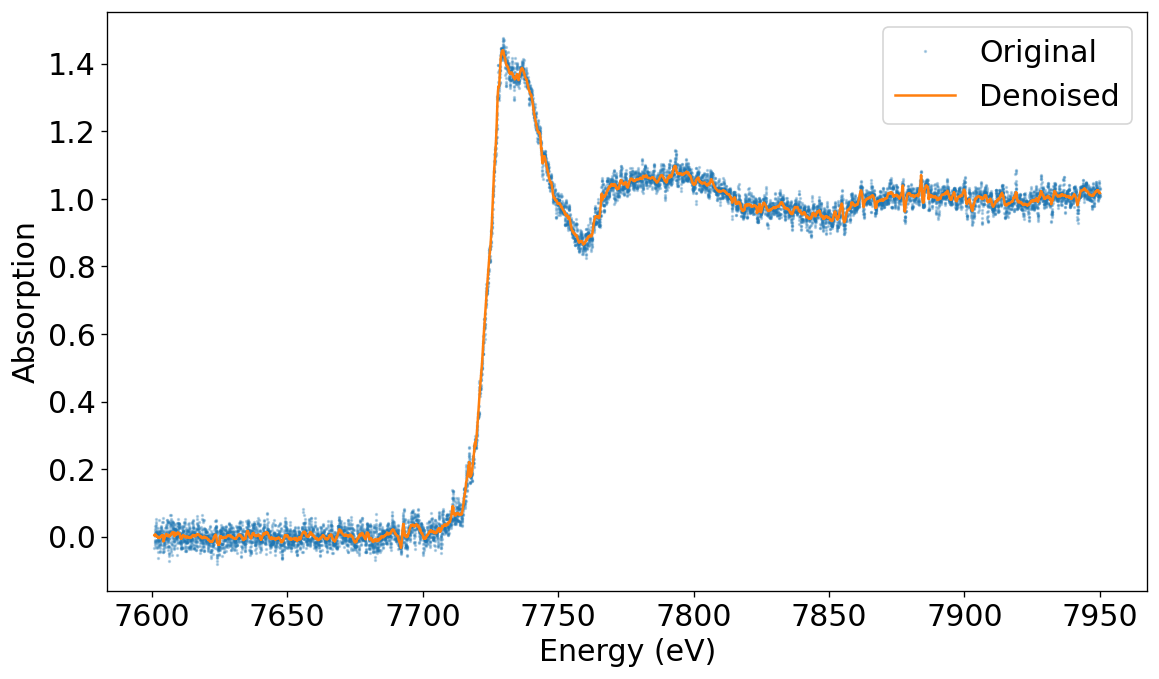

Denoising completed!


In [3]:
def simple_denoising(spectrum_obj):
    """
    Simple denoising using the denoising pipeline.
    
    Returns:
        tuple: (denoised_spectrum, error_estimates, noise_estimates)
    """
    # Create pipeline configuration
    config = PipelineConfig(
        verbose=0,
        data_baseline_removal='step',  # Model was trained with baseline removal
    )
    
    # Create denoiser
    denoiser = EncoderDenoiser(model_type='conv', num_layers=4, kernel_size=9)
    denoiser.load_model('./data/encoder_denoiser_conv_model_5000_pts_num_times_all_train_90.0_test_10.0_val_0_energy_grid_linear_in_energy_downsampled_data_warped_False_nlayers_4_kernelsize_9_noise2noise_checkpoint.pth')

    # Create and run pipeline with method chaining
    pipeline = DenoisingPipeline(config)
    pipeline.load_data(spectrum_obj).process(denoiser)
    
    # Get results
    y_denoised, y_error, y_noise = pipeline.get_results()
    
    # Plot results
    pipeline.plot_results(fig_size=(10, 6))
    return y_denoised, y_error, y_noise

# Run denoising
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = simple_denoising(spectrum_obj)

print(f"Denoising completed!")

# Perform data warping
There are multiple ways to perform data warping, which has been shown to improve data denoising performance when dealing with non-stationary data (most XAS spectra). With warping the spectrum is transformed into a domain where the data appears more stationary and results in improved denoising performance.

To enable data warping we need to set the "config.input_warping_method" from None, to one of the warping methods:
- config.input_warping_method = 'kspace' # 'kspace', 'smoothness' or 'kspace_exafs_smoothness_xanes'

For Encoder denoiser we need to interpolate onto a uniform grid for warping to work:
- config.warping_interpolation_method = 'downsample'

Using Apple Silicon MPS device.
Model loaded from ./data/encoder_denoiser_conv_model_5000_pts_num_times_all_train_90.0_test_10.0_val_0_energy_grid_linear_in_energy_downsampled_data_warped_False_nlayers_4_kernelsize_9_noise2noise_checkpoint.pth


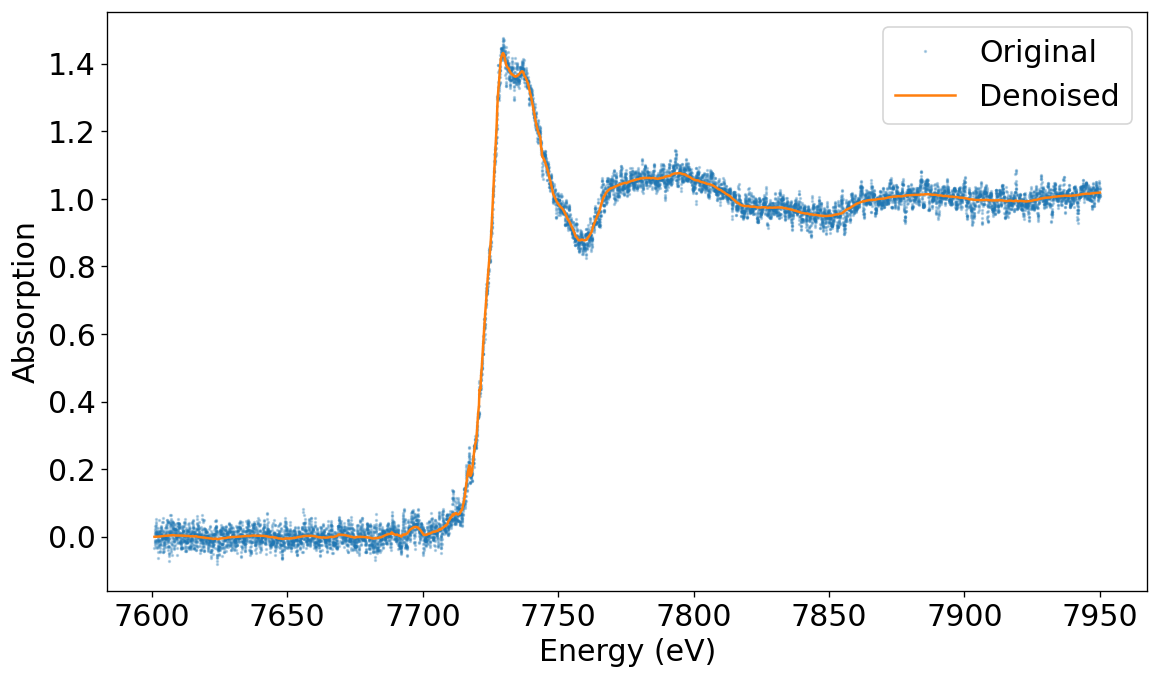

Denoising completed!


In [4]:
def simple_denoising_with_warping(spectrum_obj):
    """
    Simple denoising using the denoising pipeline with warping enabled.
    
    Returns:
        tuple: (denoised_spectrum, error_estimates, noise_estimates)
    """
    # Create pipeline configuration
    config = PipelineConfig(
        verbose=0,
        data_baseline_removal='step', # Model was trained with baseline removal
        warping_interpolation_method='downsample',
        input_warping_method='kspace',
        warping_interpolation_num_points = 2500  # Number of points in the interpolation grid (must be as close as possible to the trained model size)          
    )
    
    # Create denoiser
    denoiser = EncoderDenoiser(model_type='conv', num_layers=4, kernel_size=9)
    denoiser.load_model('./data/encoder_denoiser_conv_model_5000_pts_num_times_all_train_90.0_test_10.0_val_0_energy_grid_linear_in_energy_downsampled_data_warped_False_nlayers_4_kernelsize_9_noise2noise_checkpoint.pth')

    # Create and run pipeline with method chaining
    pipeline = DenoisingPipeline(config)
    pipeline.load_data(spectrum_obj).process(denoiser)
    
    # Get results
    y_denoised, y_error, y_noise = pipeline.get_results()
    
    # Plot results
    pipeline.plot_results(fig_size=(10, 6))
    return y_denoised, y_error, y_noise

# Run denoising
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = simple_denoising_with_warping(spectrum_obj)

print(f"Denoising completed!")